# Data:
- Geometry (area, curvature)
    - $A$, $Ms^{f}$, $<H>$.
- Topology (corner)
    - $C$, $C-<Cnn>$
- Migration
    - sign, distance
    - Energy gradient: grain & connected face
- Energy
- Crystallography
  - misorientation angle from sigma3.
  - weighted average distance from coherent twin. 
    
## Directions:
  - Prediction & Correlation.
  - In-plane evolution (area, curvature) & Out-of-plane migration
  
## Possible assumptions: 
- Faces move in a direction consistent with the energy gradient within the grain pair. 
- Faces move in a direction / with a magnitude consistent with face curvature
- Faces that are increasing in area move along with the energy gradient.
- Faces with large $C$, $Ms^{f}$, $|C - <Cnn>|_{an4}$ move long distances.
- Face migration distances are related to crystallography.
- Geometry   vs.   Geometry
- Gemoetry   vs.   Topology
- Gemoetry/Topology   vs.   Migration
- energy   vs.   mig_dist


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

geo_topo = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/final/190730_Hsmooth_geo_topo.txt')
energy_grad = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/final/190730_Hsmooth_energygrad.txt')
other = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/final/190730_Lsmooth_otherinfo_normdist_formal.txt')
mean_field = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/final/190730_Hsmooth_mean_field.txt')
# mask_good_face = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/190718_Hsmooth_mask_good_face.txt')
da = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/final/190730_Hsmooth_dihedral_ang.txt')


geo_topo.columns = geo_topo.columns.str.strip()
energy_grad.columns = energy_grad.columns.str.strip()
other.columns = other.columns.str.strip()
mean_field.columns = mean_field.columns.str.strip()
da.columns = da.columns.str.strip()
# mask_good_face.columns = mask_good_face.columns.str.strip()

geo_topo = geo_topo.drop(['fMs_signed_an4'], axis=1)

geo_topo = geo_topo.astype('float')
energy_grad = energy_grad.astype('float')
other = other.astype('float')
mean_field = mean_field.astype('float')
# mask_good_face = mask_good_face.astype('bool')
da = da.astype('float')


### EDA

In [2]:
# geo_topo.info()
# energy_grad.info()
# mean_field.info()
# other.info()

# ----------------- Paper Feature Correlation Mat -----------------
# other = other.iloc[:, :-8]
# data = pd.concat([other, geo_topo.iloc[:,[0,1,2,5,6,8,3,4]], da.iloc[:, [0,1,2]], \
#                   geo_topo.iloc[:,[9, 10]], da.iloc[:, [3,4,5]], \
#                   mean_field.iloc[:,[0,1,2,3,5,6,7,4,8,9,10,11,12]], \
#                   energy_grad], axis=1)
# ----------------- For Models -----------------
da = da[['da_len_w_an4_opp', 'da_len_w_diff_opp']]
energy_grad = energy_grad[['gV_diff_an4', 'fMs_an4_left']]
other = other.iloc[:, :-8]
data = pd.concat([other, geo_topo.iloc[:,[0,1,2,5,6,8,3,4]], da.iloc[:, 0], \
                  geo_topo.iloc[:,[9, 10]], da.iloc[:, 1], \
                  mean_field.iloc[:,[0,1,2,3,5,6,7,4,8,9,10,11,12]], \
                  energy_grad], axis=1)

data = data.dropna()

mask_complete = data['mask_complete'].astype(bool)
mask_one_piece = data['mask_onepiece'].astype(bool)
area_an4 = data[['A_an4']].values
area_an5 = data[['A_an4']].values + data[['A_diff']].values
area_diff_ratio = (area_an5 - area_an4) / area_an4
mask_not_extreme = np.all([area_an4 > 20, area_an5 > 20, area_diff_ratio < 10, area_diff_ratio > -0.9], axis=0)
# mask = np.all([mask_complete, mask_one_piece, mask_not_extreme.squeeze()], axis=0)
mask = np.all([mask_complete, mask_not_extreme.squeeze()], axis=0)
data = data[mask]

data = data.drop(['mask_complete', 'mask_onepiece'], axis=1)
data.info()


# data.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6447 entries, 82 to 10886
Data columns (total 28 columns):
dist_twin_an4         6447 non-null float64
A_an4                 6447 non-null float64
fMs_abs_an4           6447 non-null float64
avg_FabsavgH_an4      6447 non-null float64
A_diff                6447 non-null float64
fMs_abs_diff          6447 non-null float64
avg_FabsavgH_diff     6447 non-null float64
C_an4                 6447 non-null float64
E_an4                 6447 non-null float64
da_len_w_an4_opp      6447 non-null float64
C_diff                6447 non-null float64
E_diff                6447 non-null float64
da_len_w_diff_opp     6447 non-null float64
E_Enn                 6447 non-null float64
abs_gf_gfnn           6447 non-null float64
pos_frac              6447 non-null float64
twin_frac             6447 non-null float64
grow_frac             6447 non-null float64
disappeared_frac      6447 non-null float64
appeared_frac         6447 non-null float64
total_dann 

In [3]:
name_dict = {
    'dist_twin_an4':'$Dist\_\Sigma3$', 'dist_avg_111':'$Dist\_111\_Avg$', 'dist_std_111':'$Dist\_111\_Std$', \
    'dist_avg_110':'$Dist\_110\_Avg$', 'dist_std_110':'$Dist\_110\_Std$', \
    'dist_avg_100':'$Dist\_100\_Avg$', 'dist_std_100':'$Dist\_100\_Std$', \
    'A_an4':'$A$', 'fMs_abs_an4':'$\mathcal{|H|}$','avg_FabsavgH_an4':'$\mathbb{|H|}$', \
    'A_diff':'$\Delta\: A$', 'fMs_abs_diff':'$\Delta\: \mathcal{|H|}$','avg_FabsavgH_diff':'$\Delta\: \mathbb{|H|}$', \
    'C_an4':'$C$', 'E_an4':'$E$',\
    'da_len_w_an4_l':'$DA\_L$', 'da_len_w_an4_r':'$DA\_R$','da_len_w_an4_opp':'$DA\_O$',\
    'C_diff':'$\Delta\: C$', 'E_diff':'$\Delta\: E$',\
    'da_len_w_diff_l':'$\Delta\: DA\_L$', 'da_len_w_diff_r':'$\Delta\: DA\_R$','da_len_w_diff_opp':'$\Delta\: DA\_O$',\
    'E_Enn':'$E - <E_{NN}>$', 'abs_gf_gfnn':'$\mathcal{|H|} - <\mathcal{|H|}_{NN}>$',\
    'pos_frac':'$NN\_Pos\_Frac$', 'twin_frac':'$NN\_Twin\_Frac$',\
    'grow_frac':'$NN\_Grow\_Frac$', 'disappeared_frac':'$NN\_Ext\_Frac$',\
    'appeared_frac':'$NN\_Nuc\_Frac$', 'total_dann':'$sum(\Delta\: A_{NN})$',\
    'disappeared_frac_g':'$NNG\_Ext\_Frac$','appeared_frac_g':'$NNG\_Nuc\_Frac$', \
    'max_dfnn_g':'$max(\Delta\: F_{NNG})$','min_dfnn_g':'$min(\Delta\: F_{NNG})$', \
    'avg_dfnn_g':'$<\Delta\: F_{NNG}>$',\
    'dist_f_g_diff':'$\Delta\: Dist\_F\_LG$', 'gV_diff_an4':'$V\_Diff$',\
    'gF_diff_an4':'$F\_Diff$', 'gFnnF_diff_an4':'$F - <F_{NN}>\_Diff$',\
    'gMs_diff_an4':'$M_{s}\_Diff$', 'fMs_an4_left':'$\mathcal{H}$'\
    }


### Helper Functions

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          rotate_xlabel=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if not title:
#         if normalize:
#             title = 'Normalized confusion matrix'
#         else:
#             title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    if rotate_xlabel:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    # save figure
    if title:
        plt.savefig(title, dpi=300, bbox_inches="tight")
    
    return ax


def plot_correlation_matrix(df, title=None):
    # Create Correlation df
    corr = df.corr()
    # Plot figsize
    fig, ax = plt.subplots(figsize=(36, 36))

    # Drop self-correlations
    dropSelf = np.zeros_like(corr)
    dropSelf[np.triu_indices_from(dropSelf)] = True
    # Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap="Blues", annot=True, fmt=".2f", mask=dropSelf, square=True)
    # Latex
    plt.rc('text.latex', preamble='\usepackage{amsmath},\usepackage{amssymb}')
    feature_names=[]
    for name in corr.columns:
        feature_names.append(name_dict[name])
    # Apply xticks
    plt.xticks(range(len(feature_names)), feature_names, size = 16)
    # Apply yticks
    plt.yticks(range(len(feature_names)), feature_names, size = 16)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # save figure
    if title:
        plt.savefig(title, dpi=300, bbox_inches="tight")
    
    # show plot
    plt.show()

    
def plot_feature_importance(feature_importance, names, title = None):
    fig, ax = plt.subplots(figsize=(15, 6))
    plt.rc('text.latex', preamble='\usepackage{amsmath},\usepackage{amssymb}')
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.yticks(fontsize=16)
    plt.xticks(range(len(feature_importance)), names, size = 16)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    if title:
        plt.savefig(title, dpi=300, bbox_inches="tight")


def plot_scatter_overlay(slope, intercept, x_train, y_train, x_test=None, y_test=None, title=None):
    plt.figure()
    x_line = np.linspace(np.min(x_train),np.max(x_train),10)
    y_line = slope * x_line + intercept
    plt.rc('text.latex', preamble='\usepackage{amsmath},\usepackage{amssymb}')
    plt.scatter(x_train, y_train, s=12)
    if np.any(x_test):
        plt.scatter(x_test, y_test, s=12, marker='^')
    plt.plot(x_line, y_line, 'r')
    
    if title:
        plt.title(title)
        plt.savefig(title, dpi=300, bbox_inches="tight")
    plt.show()


def forward_selected(data_train, data_test, response):
    """
    !!!!! OLD, see forward_selected_cross_val !!!!!
    Linear model designed by forward selection.
    -----------
    data : pandas DataFrame with all possible predictors and response
    response: string, name of response column in data
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data_train.columns)
    remaining.remove(response)
    current_score, best_new_score = 0.0, 0.0
    selected = []
    best_scores = []
    best_tests = []
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            # ----- fit model -----
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            model_tmp = smf.ols(formula, data_train).fit()
            score_train = model_tmp.rsquared_adj
            # ----- calculate test score -----
            y_predict = model_tmp.predict(data_test.loc[:, data_test.columns!=response])
            r2_test = r2_score(data_test[response], y_predict)
            m = float(data_test.shape[0])
            k = float(data_test.shape[1])
            score_test = 1 - (1-r2_test)*((m-1)/(m-k-1))
            # ----- append results -----
            scores_with_candidates.append((score_train, score_test, candidate))
            
        scores_with_candidates.sort()
        best_new_score, best_new_test, best_candidate = scores_with_candidates.pop()
        best_scores.append(best_new_score)
        best_tests.append(best_new_test)
        selected.append(best_candidate)
        if current_score < best_new_score:
            remaining.remove(best_candidate)
#             formula.append("{} ~ {} + 1".format(response, ' + '.join(selected)))
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data_train).fit()
    return model, selected, best_scores, best_tests


def adjust_r2(n, k, r2):
    """
    n: number of data entries
    k: number of regressor
    r2: r2 score
    -----
    r2_adjust: adjusted r2
    -----
    Ref: https://www.statisticshowto.datasciencecentral.com/adjusted-r2/
    """
    r2_adjust = 1 - (1 - r2)*(n - 1)/(n - k -1)
    return r2_adjust

def forward_selected_cross_val(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)    
    n_train = np.floor(data.shape[0]*0.8)
    n_test = np.floor(data.shape[0]*0.2)
    best_cur_score, best_new_score = 0.0, 0.0    
    selected = []
    best_trains = []
    best_tests = []
    model = LinearRegression()
    while remaining and best_cur_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            selected.append(candidate)
            # ----- Fit Model -----
            cross_val_scores = cross_validate(model, data[selected], data[response], cv=5, scoring = 'r2', return_train_score=True)
            score_train = sum(cross_val_scores['train_score']) / len(cross_val_scores['train_score'])
            score_test = sum(cross_val_scores['test_score']) / len(cross_val_scores['test_score'])
            # ----- adjust R2 score for the training data -----
            k = len(selected)
            score_train = adjust_r2(n_train, k, score_train)

            # ----- append results -----
            scores_with_candidates.append((score_train, score_test, candidate))
            selected.pop()

        scores_with_candidates.sort()
        best_new_score, best_new_test, best_candidate = scores_with_candidates.pop()
        best_trains.append(best_new_score)
        best_tests.append(best_new_test)
        selected.append(best_candidate)

        if best_cur_score < best_new_score:
            remaining.remove(best_candidate)
            best_cur_score = best_new_score
    return selected, best_trains, best_tests


def plot_forward_selection(train_score, test_score, feature_names, title=None):
    fig = plt.figure(figsize=(10, 5), dpi=300)
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()

    x_axis = np.arange(len(train_score)) + 1
    plt.rc('text.latex', preamble='\usepackage{amsmath},\usepackage{amssymb}')
    ax1.plot(x_axis, train_score, '-o', color = 'k', label='Train')
    ax1.plot(x_axis, test_score, '-o', color = 'r', label='Test')
    ax1.set_xlabel('$\#$ Features',  usetex=True, size=18)
    ax1.set_ylabel('(Adjusted) $R^2$', usetex=True, size=18)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(x_axis)
    ax2.set_xticklabels(feature_names)
#     ax2.tick_params(axis='x', which='major', pad=10)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="left",
             rotation_mode="anchor")
    ax1.legend(loc=4, prop={'size': 14})
    
    if title:
        plt.savefig(title, dpi=300, bbox_inches="tight")
        
    # plt.ylim((0, 0.3)) 
    plt.show()
    
    
    
def get_sign(data, eps):
    data_sign = np.zeros([data.shape[0], 1])
    mask_pos = data > eps
    mask_neg = data < - eps
    data_sign[mask_pos] = 1
    data_sign[mask_neg] = -1
    return data_sign.ravel()

def continuous_to_catigorical_equal_binsize(data, low_prctile, high_prctile, num_bins):
    low = np.percentile(data, low_prctile, axis=0)
    high = np.percentile(data, high_prctile, axis=0)
    step_size = (high - low) / num_bins
    bin_edge = np.array([float('-inf')] + list(np.arange(low, high+0.001, step_size)) + [float('inf')])
    data_binned = pd.cut(data, bin_edge, labels=False)
    return data_binned.ravel()

def continuous_to_catigorical_pertentile(data, num_bins):
    data_binned = pd.qcut(data, num_bins, labels=False)
    return data_binned.ravel()

def calc_class_weights(y):
    weights = np.ones(y.shape)
    for _class in np.unique(y):
        weights[y==_class] = float(np.sum(y==_class)) / y.shape[0]
    return weights

# Categorize data
- Helper functions
    - get_sign(data, eps)
    - continuous_to_catigorical_equal_binsize(data, low_prctile, high_prctile, num_bins)
    - continuous_to_catigorical_pertentile(data, num_bins)

In [5]:
# # ------------------------------ Migration Direction, From Δ(centroid) ------------------------------
# eps_motion = 0.005
# move_left_centr = get_sign(dist_f_g_diff, eps_motion)
# move_left = move_left_centr
# move_left_ind = MultiLabelBinarizer().fit_transform(move_left)

# plt.figure()
# plt.hist(move_left, bins=[-1, 0, 1, 2], density = True, alpha = 0.2, color= 'k')
# plt.xticks([-0.5, 0.5, 1.5], ['-1', '0', '1'], size=15)
# plt.yticks(size=15)
# plt.ylabel('Probability',size=16)
# plt.xlabel('Direction Of Migration',size=16)
# plt.savefig(fig_name, dpi=300, bbox_inches="tight")



# # ---------------------- Migration Direction, From Local Norm Projection ----------------------
# mig_left_normproj = mig['mig_left_normproj']

# eps = 0.5
# move_left_direct = get_sign(mig_left_normproj, eps)
# print 'stable = ', np.sum(move_left_direct == 0), '; move_left = ', np.sum(move_left_direct > 0), \
#         'move_right = ', np.sum(move_left_direct < 0)


# # -------------------------------------- Sign Of A_diff --------------------------------------
eps_area = 20
area_diff_sign = get_sign(data['A_diff'], eps_area)
print '#stable = ', np.sum(area_diff_sign == 0), ';   #grow = ', np.sum(area_diff_sign > 0), \
    ';   #shrink = ', np.sum(area_diff_sign < 0)
    
    
# # -------------------------------------- Rank Of A_diff --------------------------------------
# low_prctile = 5
# high_prctile = 95
# num_bins = 4
# area_diff_rank = continuous_to_catigorical_equal_binsize(data['A_diff'], low_prctile, high_prctile, num_bins)
# plt.hist(area_diff_rank)



#stable =  937 ;   #grow =  2478 ;   #shrink =  3032


# Logistic Regression, Vanilla

In [29]:
from sklearn.linear_model import LogisticRegression

y = energy_grad.iloc[:, 0]
X = energy_grad.iloc[:, 1:]

# y = mig_sign.mig_n2_sign_ot
# X = energy_grad.iloc[:, 1:]
# mask_onepiece = other.iloc[:,0].astype('bool').values
# X = X[mask_onepiece]

logi_reg = LogisticRegression()

logi_reg.fit(X, y)
print logi_reg.coef_
# print lasso.intercept_
print 'accuracy: ', logi_reg.score(X, y)

# Logistic Regression, Lasso
- Notes
    - only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes
    - only ‘liblinear’ and ‘saga’ handle L1 penalty.
- Parameter importance 
    - np.std(X, 0) * clf.coef_ 
        - https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model
- Results
    - L1 & L2
        - Accuracy is similar, but coefs very different
    - 'liblinear' + 'ovr' (one versus all) & 'saga' + 'multinomial'
        - The prediction accuracy is similar.
        - The feature selection effect is much more clear in 'saga' + 'multinomial'.

In [23]:
rand_idx = 0

# ------------ Data -------------
# ------------------
# y = move_left
# X = data.drop(['dist_f_g_diff'], axis=1)
# figure_name = '190730_move_left_logiReg_Hsmooth'
# ------------------
y = area_diff_sign
X = data.drop(['A_diff', 'fMs_abs_diff'], axis=1)
figure_name = '190730_area_diff_sign_logiReg_Hsmooth'
# ------------------
# y = area_diff_rank
# X = data.drop(['A_diff', 'fMs_abs_diff'], axis=1)
# figure_name = '190730_area_diff_rank_logiReg_Hsmooth'
# ------------------
# y = data['mask_complete']
# X = data.drop(['mask_complete',], axis=1)
# figure_name = '190730_mask_complete_logiReg_Hsmooth'
# ------------------
X = X / X.max(axis=0) *10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_idx)



# ------------ Model -------------
logi_reg = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=5000, C=0.1)
# logi_reg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000, C = 0.1)


# ------------ Results -------------
logi_reg.fit(X_train, y_train)
print 'training score =', np.round(logi_reg.score(X_train, y_train), 4)
print 'test score =', np.round(logi_reg.score(X_test, y_test), 4)
print classification_report(y_test, logi_reg.predict(X_test))

plot_confusion_matrix(y_train, logi_reg.predict(X_train), classes=range(min(y), max(y)+1))
plt.figure()
plot_confusion_matrix(y_test, logi_reg.predict(X_test), classes=range(min(y), max(y)+1))



### Tuning C

In [24]:
logi_reg = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=5000)


param_test =  {
     'C':[0.01, 0.1, 1, 10, 100, 1000]
#     'C':[i/2.0 + 0.1 for i in range(0, 10, 2)]
}

# scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
gsearch = GridSearchCV(estimator = logi_reg, param_grid = param_test, cv=5, return_train_score=False)
gsearch.fit(X, y)
gsearch.best_params_, gsearch.best_score_


({'C': 100}, 0.5931440980300915)

### Final results

In [26]:
best_c = gsearch.best_params_['C']
logi_reg = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=5000, C = best_c)

cv_results = cross_validate(logi_reg, X, y, cv=5, return_train_score=True)
print sorted(cv_results.keys()) 
print 'test accuracy = ', np.round(cv_results['test_score'], 4), np.round(cv_results['test_score'].mean(), 4)
print 'training accuracy = ', np.round(cv_results['train_score'], 4), np.round(cv_results['train_score'].mean(), 4)

# logi_reg.fit(X_train, y_train)
# plotConfusionMatrix(y_train, logi_reg.predict(X_train), ['-1', '0', '1'], normalize=False, rotate_xlabel=False, title=figure_name + '_train')
# plt.figure()
# plotConfusionMatrix(y_test, logi_reg.predict(X_test), ['-1', '0', '1'], normalize=False, rotate_xlabel=False, title=figure_name + '_test')
# plt.figure()
# plotFeatureImportance(logi_reg.coef_[0,:], X.columns, title=figure_name)
# np.savetxt(figure_name + '_coefs.txt', logi_reg.coef_[0,:], delimiter=',') 
# np.savetxt(figure_name + '_feature_names.txt', X.columns, delimiter=',', fmt='%20s') 

['fit_time', 'score_time', 'test_score', 'train_score']
test accuracy =  [0.5933 0.5701 0.578  0.625  0.5994] 0.5932
training accuracy =  [0.595  0.6014 0.6024 0.5912 0.5997] 0.598


# RFE
Feature ranking with recursive feature elimination.

In [38]:
from sklearn.feature_selection import RFE

y = energy_grad.iloc[:, 0]
X = energy_grad.iloc[:, 1:]

estimator = LogisticRegression()
selector = RFE(estimator, 3, step=1)
selector = selector.fit(X, y)
print selector.support_ 
print selector.ranking_

[ True  True  True False False False False False False]
[1 1 1 3 2 7 4 6 5]


# XGboost
- refs:
    - https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    - https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/
- sample weights
    - https://stackoverflow.com/questions/42192227/xgboost-python-classifier-class-weight-option

### Default model

In [6]:
num_class = 3
# # -------
# objective = 'multi:softmax'
# eval_metric = 'auc'
# -------
objective = 'multi:softprob'
eval_metric='mlogloss'

# ------------------- Data -------------------
y = area_diff_sign
X = data.drop(['A_diff', 'fMs_abs_diff'], axis=1)
# X = data[['fMs_abs_an4', 'abs_gf_gfnn', 'E_diff', 'disappeared_frac_g']]
figure_name = '190730_area_diff_sign_xgboost_Hsmooth_mlogloss'
class_labels = ['shrink', 'stable', 'grow']

X = X / X.max(axis=0) *10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# ------------------- Data weight -------------------
weights_train = calc_class_weights(y_train)
weights_test = calc_class_weights(y_test)
weights = calc_class_weights(y)

# ------------------- Model -------------------
xgb1 = XGBClassifier(
                     eval_metric=eval_metric,
                     num_class=num_class,
                     objective=objective,
                     learning_rate =0.1,
                     n_estimators=500,
                     max_depth=3,
                     min_child_weight=1,
                     gamma=0,
                     colsample_bytree=0.3
                    )

# # ------------------- Results -------------------
# xgb1.fit(X_train, y_train, sample_weight = weights_train)
# print 'training score =', np.round(xgb1.score(X_train, y_train), 3), 'test score =', np.round(xgb1.score(X_test, y_test), 3)
# print 'test report'
# print classification_report(y_test, xgb1.predict(X_test))

# plotConfusionMatrix(y_train, xgb1.predict(X_train), class_labels)
# plt.figure()
# plotConfusionMatrix(y_test, xgb1.predict(X_test), class_labels)

### Tune    n_estimators

In [8]:
xgb_best = XGBClassifier(
                         eval_metric=eval_metric,
                         num_class=num_class,
                         objective=objective,
                         learning_rate=0.1,
                        )

param_test =  {
#  'n_estimators':[200, 500, 1000, 2000]
    'n_estimators': range(800, 1700, 200)
}

gsearch = GridSearchCV(estimator = xgb_best, param_grid = param_test, cv=5, return_train_score=True)
gsearch.fit(X, y, sample_weight = weights)
gsearch.best_params_, gsearch.best_score_


({'n_estimators': 1000}, 0.7054443927408097)

### Tune 1. max_depth & min_child_weight

In [9]:
best_n_estimators = gsearch.best_params_['n_estimators']

xgb_best = XGBClassifier(
                         eval_metric=eval_metric,
                         num_class=num_class,
                         objective=objective,
                         learning_rate =0.1,
                         n_estimators=best_n_estimators,
                        )

param_test_1 = {
 'max_depth':range(2, 7, 1),
 'min_child_weight':range(1, 7, 1)
#  'max_depth':range(2, 4, 1),
#  'min_child_weight':range(1, 4, 1)
}

gsearch1 = GridSearchCV(estimator = xgb_best, param_grid = param_test_1, cv=5, return_train_score=False)
gsearch1.fit(X, y, sample_weight = weights)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 4, 'min_child_weight': 3}, 0.7097874980611137)

### Tune 2. gamma 

In [33]:
best_depth = gsearch1.best_params_['max_depth']
best_min_child_weight = gsearch1.best_params_['min_child_weight']

xgb_best = XGBClassifier(
                         eval_metric=eval_metric,
                         num_class=num_class,
                         objective=objective,
                         learning_rate =0.1,
                         n_estimators=best_n_estimators,
                         max_depth=best_depth,
                         min_child_weight=best_min_child_weight
                         )

param_test_2 =  {
    'gamma':[0.0, 0.1, 1.0, 10.0, 100.0, 1000.0]
#  'gamma':[i/1.0 for i in range(1, 10, 2)]
#     'gamma':[10.0, 1000.0, 2e3, 3e3, 4e3]
}

gsearch2 = GridSearchCV(estimator = xgb_best, param_grid = param_test_2, cv=5, return_train_score=False)
gsearch2.fit(X, y, sample_weight = weights)
gsearch2.best_params_, gsearch2.best_score_

### Tune 3. subsample & colsample_bytree, learning rate

In [12]:
best_depth = gsearch1.best_params_['max_depth']
best_min_child_weight = gsearch1.best_params_['min_child_weight']
# -------------------------------- Regularization --------------------------------------
# best_gamma = gsearch2.best_params_['gamma']
best_gamma = 0.0

xgb_best = XGBClassifier(
                         eval_metric=eval_metric,
                         num_class=num_class,
                         objective=objective,
                         learning_rate =0.1,
                         n_estimators=best_n_estimators,
                         max_depth=best_depth,
                         min_child_weight=best_min_child_weight,
                         gamma=best_gamma
                         )

param_test_3 =  {
 'colsample_bytree':[i/100.0 for i in range(30, 101, 10)],
 'subsample':[i/100.0 for i in range(50,101,10)]
}
gsearch3 = GridSearchCV(estimator = xgb_best, param_grid = param_test_3, cv=5, return_train_score=False)
gsearch3.fit(X, y, sample_weight = weights)
print 'gsearch3: ', gsearch3.best_params_, gsearch3.best_score_

best_colsample_bytree = gsearch3.best_params_['colsample_bytree']
best_subsample =  gsearch3.best_params_['subsample']

# -------------------------------- Learning Rate --------------------------------------
xgb_best = XGBClassifier(
                         eval_metric=eval_metric,
                         num_class=num_class,
                         objective=objective,
                         n_estimators=best_n_estimators,
                         max_depth=best_depth,
                         min_child_weight=best_min_child_weight,
                         gamma=best_gamma,
                         colsample_bytree=best_colsample_bytree,
                         subsample=best_subsample
                         )

param_test_4 =  {
 'learning_rate':[0.02, 0.05, 0.1, 0.15, 0.2]
}

gsearch4 = GridSearchCV(estimator = xgb_best, param_grid = param_test_4, cv=5, return_train_score=False)
gsearch4.fit(X, y, sample_weight = weights)
print gsearch4.best_params_, gsearch4.best_score_

best_learning_rate =  gsearch4.best_params_['learning_rate']

# -------------------------------- Final Model --------------------------------------
xgb_best = XGBClassifier(
                         eval_metric=eval_metric,
                         num_class=num_class,
                         objective=objective,
                         learning_rate=best_learning_rate,
                         n_estimators=best_n_estimators,
                         max_depth=best_depth,
                         min_child_weight=best_min_child_weight,
                         gamma=best_gamma,
                         colsample_bytree=best_colsample_bytree,
                         subsample=best_subsample
                         )

cross_val_scores = cross_validate(xgb_best, X, y, cv=5, return_train_score=True)
print 'cross validation, train AUC = ', np.round(sum(cross_val_scores['train_score']) / len(cross_val_scores['train_score']), 4)
print 'cross validation, test AUC = ', np.round(sum(cross_val_scores['test_score']) / len(cross_val_scores['test_score']), 4)


print ' '
print 'X = ', list(X.columns)
print ' '
print figure_name

gsearch3:  {'subsample': 0.9, 'colsample_bytree': 0.7} 0.7111834961997828
{'learning_rate': 0.05} 0.7131999379556383
cross validation, train AUC =  0.9699
cross validation, test AUC =  0.7121
 
X =  ['dist_twin_an4', 'A_an4', 'fMs_abs_an4', 'avg_FabsavgH_an4', 'avg_FabsavgH_diff', 'C_an4', 'E_an4', 'da_len_w_an4_opp', 'C_diff', 'E_diff', 'da_len_w_diff_opp', 'E_Enn', 'abs_gf_gfnn', 'pos_frac', 'twin_frac', 'grow_frac', 'disappeared_frac', 'appeared_frac', 'total_dann', 'disappeared_frac_g', 'appeared_frac_g', 'max_dfnn_g', 'min_dfnn_g', 'avg_dfnn_g', 'gV_diff_an4', 'fMs_an4_left']
 
190730_area_diff_sign_xgboost_Hsmooth_mlogloss


### Plots

multi:softmax
{'learning_rate': 0.05}
{'n_estimators': 1000}
{'max_depth': 4, 'min_child_weight': 3}
{'gamma': 0.0}
{'subsample': 0.9, 'colsample_bytree': 0.7}


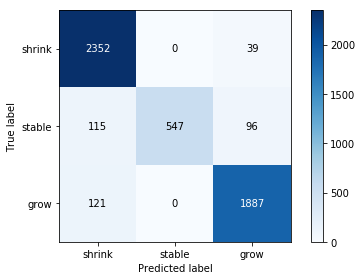

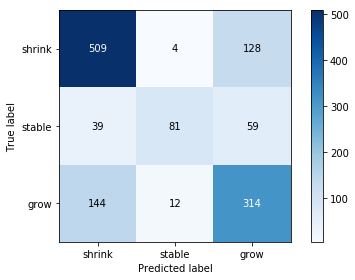

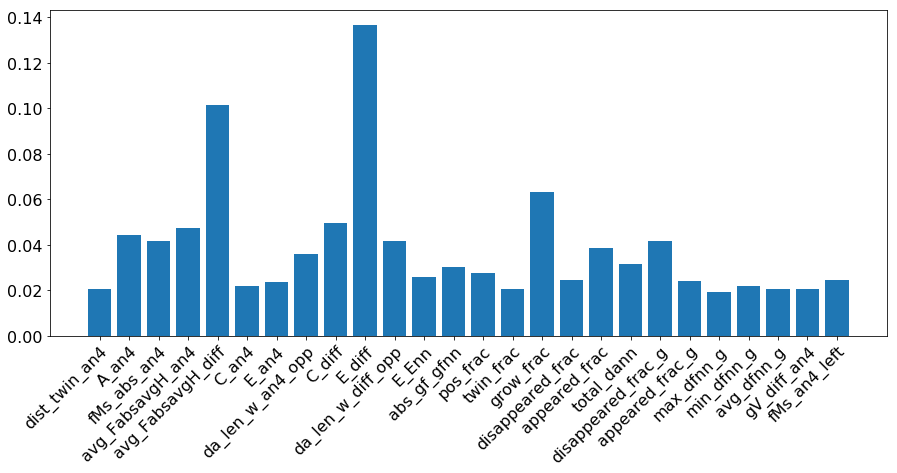

In [38]:
# y = area_diff_sign
# X = data.drop(['A_diff', 'fMs_abs_diff'], axis=1)
# figure_name = '190730_area_diff_sign_xgboost_Hsmooth'
# class_labels = ['shrink', 'stable', 'grow']

# X = X / X.max(axis=0) *10
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# weights_train = calc_class_weights(y_train)
# weights_test = calc_class_weights(y_test)
# weights = calc_class_weights(y)

# xgb_best = XGBClassifier(
#                          eval_metric='auc',
#                          objective='multi:softmax',
#                          learning_rate =0.1,
#                          n_estimators=500,
#                          max_depth=5,
#                          min_child_weight=5,
#                          gamma=1,
#                          colsample_bytree=0.9,
#                          subsample=0.9
#                          )

# cross_val_scores = cross_validate(xgb_best, X, y, cv=5, return_train_score=True)
# print 'cross validation, train AUC = ', np.round(sum(cross_val_scores['train_score']) / len(cross_val_scores['train_score']), 4)
# print 'cross validation, test AUC = ', np.round(sum(cross_val_scores['test_score']) / len(cross_val_scores['test_score']), 4)







print objective
print gsearch4.best_params_
print gsearch.best_params_
print gsearch1.best_params_
print gsearch2.best_params_
print gsearch3.best_params_

xgb_best.fit(X_train, y_train, sample_weight = weights_train)

plot_confusion_matrix(y_train, xgb_best.predict(X_train), class_labels, normalize=False, rotate_xlabel=False, title=figure_name + '_train')
plt.figure()
plot_confusion_matrix(y_test, xgb_best.predict(X_test), class_labels, normalize=False, rotate_xlabel=False, title=figure_name + '_test')
plt.figure()
plot_feature_importance(xgb1.feature_importances_, X.columns, title=figure_name)

np.savetxt(figure_name + '_coefs.txt', xgb_best.feature_importances_, delimiter=',') 
np.savetxt(figure_name + '_names.txt', X.columns, delimiter=',', fmt='%20s') 

In [17]:
xgb_best = XGBClassifier(
                         eval_metric='auc',
                         objective='multi:softmax',
                         learning_rate =0.1,
                         n_estimators=1000,
                         max_depth=4,
                         min_child_weight=3,
                         gamma=0,
                         colsample_bytree=0.9,
                         subsample=0.7
                         )

cross_val_scores = cross_validate(xgb_best, X, y, cv=5, return_train_score=True)
print 'cross validation, train AUC = ', np.round(sum(cross_val_scores['train_score']) / len(cross_val_scores['train_score']), 4)
print 'cross validation, test AUC = ', np.round(sum(cross_val_scores['test_score']) / len(cross_val_scores['test_score']), 4)

xgb_best = XGBClassifier(
                         eval_metric='mlogloss',
                         objective='multi:softprob',
                         learning_rate =0.1,
                         n_estimators=1000,
                         max_depth=4,
                         min_child_weight=3,
                         gamma=0,
                         colsample_bytree=0.9,
                         subsample=0.7
                         )

cross_val_scores = cross_validate(xgb_best, X, y, cv=5, return_train_score=True)
print 'cross validation, train AUC = ', np.round(sum(cross_val_scores['train_score']) / len(cross_val_scores['train_score']), 4)
print 'cross validation, test AUC = ', np.round(sum(cross_val_scores['test_score']) / len(cross_val_scores['test_score']), 4)





cross validation, train AUC =  0.9999
cross validation, test AUC =  0.7084
cross validation, train AUC =  0.9999
cross validation, test AUC =  0.7084


# Random Forest
refs:
 - https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
 - https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

/Users/xiaotingzhong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


training score = 1.0 test_score = 0.5255579553635709


/Users/xiaotingzhong/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


['fit_time', 'score_time', 'test_score', 'train_score']
[0.52877698 0.53818444 0.5295389  0.53530259 0.53314121]
[1. 1. 1. 1. 1.]
[0.52877698 0.53818444 0.5295389  0.53530259 0.53314121] 0.532988825078266
[1. 1. 1. 1. 1.] 1.0


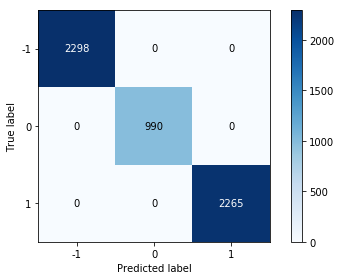

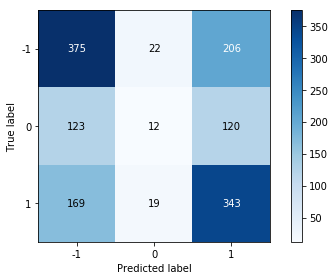

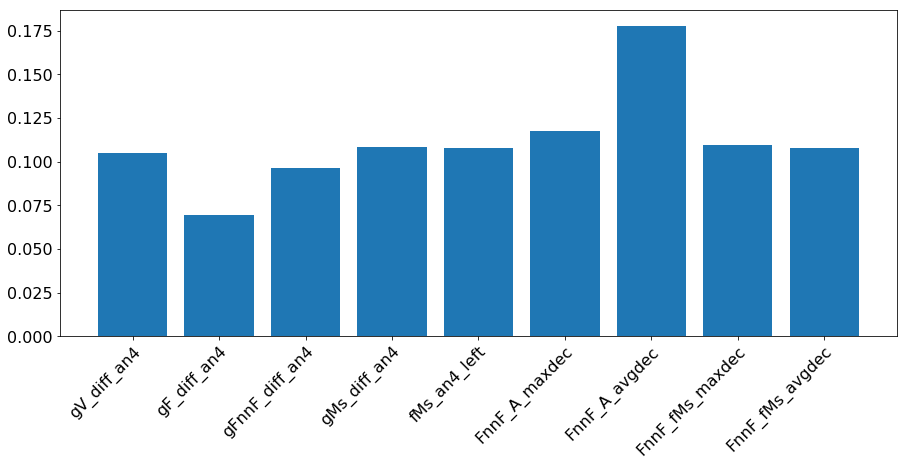

In [185]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# energy_grad = pd.read_csv('/Users/xiaotingzhong/Documents/Matlab/Grain Tracking/190408_features_energygrad.txt')
X = energy_grad.iloc[:, 1:]
# X = pd.concat([energy_grad.iloc[:, 1:], geo_topo.iloc[:,:5], other.iloc[:, 1:]], axis=1)
y = move_left
# y_onehot = pd.get_dummies(y)


rf = RandomForestClassifier(n_estimators = 1000, max_features=5, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
rf.fit(X_train, y_train);


print 'training score =', rf.score(X_train, y_train), 'test_score =', rf.score(X_test, y_test)
conf_mat =  confusion_matrix(y_test, rf.predict(X_test))
plotConfusionMatrix(y_train, rf.predict(X_train), ['-1', '0', '1'], normalize=False, rotate_xlabel=False, title='RF_train_confmat')
plt.figure()
plotConfusionMatrix(y_test, rf.predict(X_test), ['-1', '0', '1'], normalize=False, rotate_xlabel=False, title='RF_test_confmat')
plt.figure()
plotFeatureImportance(rf.feature_importances_, X.columns, title='RF_feature_importance')

np.savetxt('_coefs.txt', rf.feature_importances_, delimiter=',') 
np.savetxt('_feature_names.txt', X.columns, delimiter=',', fmt='%20s') 

cv_results = cross_validate(rf, X, y, cv=5, return_train_score=True)
print sorted(cv_results.keys()) 
print cv_results['test_score']
print cv_results['train_score']
print cv_results['test_score'], cv_results['test_score'].mean()
print cv_results['train_score'], cv_results['train_score'].mean()

# CCA 
- To checks:
    - $R_c$ (canonical correlations) and $R_c^2$ (total variance explained by each canonical variate)
    - Helio plot, for correlation between X, Y and each cannonical variate (??? pair ???)(Mandal Fig.9)
        - https://andrewpwheeler.wordpress.com/2013/06/27/some-discussion-on-circular-helio-bar-charts-2/
    - Canonical variate redundancy plot (Mandal Fig.8)
    - Canonical variate pair plots, cv_x vs. cv_y. (Mandal Fig.7)

In [290]:
from sklearn.cross_decomposition import CCA

X = energy_grad
Y = geo_topo


cca = CCA(n_components=10)
cca.fit(X, Y)

U, V = cca.transform(X, Y)
for i in range(10):
    corr = np.corrcoef(U[:,i], V[:,i])[0,1]
    print np.round(corr, 4)

print cca.coef_

0.1134
0.0839
0.0702
0.0601
0.0456
0.0312
0.0268
0.0153
0.0102
0.0017
[[-1.14230620e+02  4.34652501e+00  3.36004720e-01 -2.87462001e+00
  -1.68125547e+00 -1.54075192e+02 -4.08901514e+01  7.90808214e+00
   2.27286098e+00  1.37468668e+00]
 [-1.46783510e+03 -2.55146785e+01  4.84587763e-02  6.07564481e+00
   4.74962866e+00  3.35535104e+01 -1.40393922e+01  1.89849817e+01
  -5.57524458e+00 -5.06167466e+00]
 [-2.57662937e+03 -5.15511482e+01 -2.52342939e-01 -1.07333569e+01
  -5.53053316e+00  4.01192432e+02  8.12371533e+00  4.47600883e+00
   7.47153939e+00  1.81621547e+00]
 [ 4.20756630e+03  1.26470563e+02 -1.13214782e-01  8.03931941e+00
   5.06336136e+00 -6.62454377e+02 -4.41186540e+01 -2.31604852e+01
  -4.45350904e+00 -1.29395329e+00]
 [-1.76386189e+02 -5.90413133e+01  5.52152100e-01  5.86754228e-01
  -4.39589183e-01  5.02325108e+02  6.31160727e+01  5.27138591e+00
  -2.68271412e+00 -1.43792566e+00]
 [ 3.22944503e+02 -9.80065799e+00 -8.07695763e-01 -8.77724648e-01
  -8.60654098e-01  2.00590991

In [48]:
mig = pd.read_csv('/Users/xiaotingzhong/Documents/Matlab/Grain Tracking/190408_features_energygrad.txt')
mig_new = pd.read_csv('/Users/xiaotingzhong/Documents/Matlab/Grain Tracking/190408_features_energygrad_new.txt')

np.sum(mig.iloc[:,0] == mig_new.iloc[:,0])

4522

In [51]:
float(4522) / mig.shape[0]

0.6456310679611651

{'max_depth': 2, 'min_child_weight': 6} 0.5526601520086862
{'gamma': 0.1} 0.5532805956258725
gsearch3:  {'subsample': 1.0, 'colsample_bytree': 0.3} 0.5568481464246936
{'learning_rate': 0.05} 0.5568481464246936
cross validation, train AUC =  0.5809
cross validation, test AUC =  0.5558
 
X =  ['fMs_abs_an4', 'E_diff', 'avg_FabsavgH_an4', 'grow_frac']
 
190730_area_diff_sign_xgboost_Hsmooth_3
multi:softmax
{'learning_rate': 0.05}
{'n_estimators': 200}
{'max_depth': 2, 'min_child_weight': 6}
{'gamma': 0.1}
{'subsample': 1.0, 'colsample_bytree': 0.3}


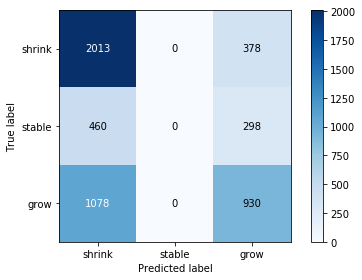

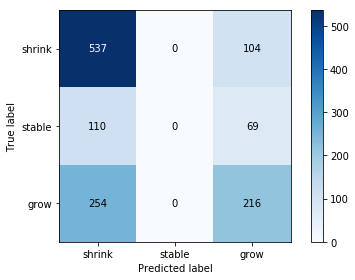

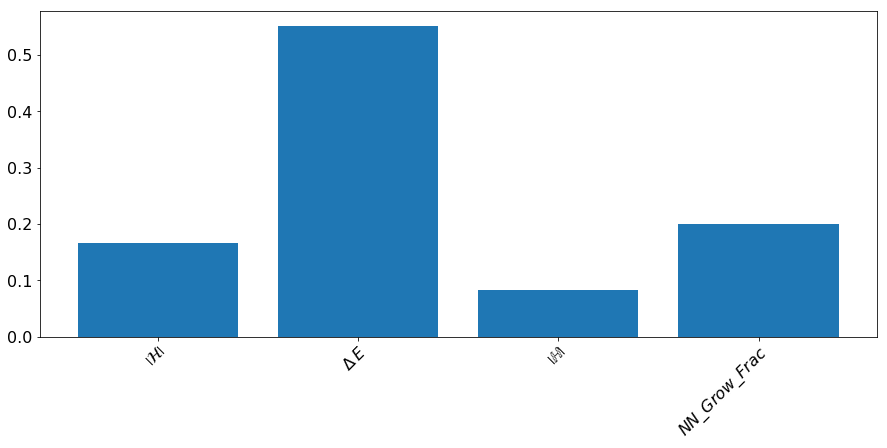

In [46]:
objective = 'multi:softmax'
# objective = 'reg:logistic'

# ------------------- Data -------------------
y = area_diff_sign
# X = data.drop(['A_diff', 'fMs_abs_diff'], axis=1)
X = data[['fMs_abs_an4', 'E_diff', 'avg_FabsavgH_an4', 'grow_frac']]
figure_name = '190730_area_diff_sign_xgboost_Hsmooth_3'
class_labels = ['shrink', 'stable', 'grow']

X = X / X.max(axis=0) *10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# ------------------- Data weight -------------------
weights_train = calc_class_weights(y_train)
weights_test = calc_class_weights(y_test)
weights = calc_class_weights(y)



xgb_best = XGBClassifier(
                         eval_metric='auc',
                         objective=objective,
                         learning_rate=0.1,
                        )

# param_test =  {
#  'n_estimators':[200, 500, 1000, 2000]
# #     'n_estimators': range(800, 1700, 200)
# }

# gsearch = GridSearchCV(estimator = xgb_best, param_grid = param_test, cv=5, return_train_score=True)
# gsearch.fit(X, y, sample_weight = weights)
# print gsearch.best_params_, gsearch.best_score_
# best_n_estimators = gsearch.best_params_['n_estimators']
best_n_estimators = 500

xgb_best = XGBClassifier(
                         eval_metric='auc',
                         objective=objective,
                         learning_rate =0.1,
                         n_estimators=best_n_estimators,
                        )

param_test_1 = {
 'max_depth':range(2, 7, 1),
 'min_child_weight':range(1, 7, 1)
#  'max_depth':range(2, 4, 1),
#  'min_child_weight':range(1, 4, 1)
}

gsearch1 = GridSearchCV(estimator = xgb_best, param_grid = param_test_1, cv=5, return_train_score=False)
gsearch1.fit(X, y, sample_weight = weights)
print gsearch1.best_params_, gsearch1.best_score_

best_depth = gsearch1.best_params_['max_depth']
best_min_child_weight = gsearch1.best_params_['min_child_weight']

xgb_best = XGBClassifier(
                         eval_metric='auc',
                         objective=objective,
                         learning_rate =0.1,
                         n_estimators=best_n_estimators,
                         max_depth=best_depth,
                         min_child_weight=best_min_child_weight
                         )

param_test_2 =  {
    'gamma':[0.0, 0.1, 1.0, 10.0, 100.0, 1000.0]
#  'gamma':[i/1.0 for i in range(1, 10, 2)]
#     'gamma':[10.0, 1000.0, 2e3, 3e3, 4e3]
}

gsearch2 = GridSearchCV(estimator = xgb_best, param_grid = param_test_2, cv=5, return_train_score=False)
gsearch2.fit(X, y, sample_weight = weights)
print gsearch2.best_params_, gsearch2.best_score_

# -------------------------------- Regularization --------------------------------------
best_gamma = gsearch2.best_params_['gamma']

xgb_best = XGBClassifier(
                         eval_metric='auc',
                         objective=objective,
                         learning_rate =0.1,
                         n_estimators=best_n_estimators,
                         max_depth=best_depth,
                         min_child_weight=best_min_child_weight,
                         gamma=best_gamma
                         )

param_test_3 =  {
 'colsample_bytree':[i/100.0 for i in range(30, 101, 10)],
 'subsample':[i/100.0 for i in range(50,101,10)]
}
gsearch3 = GridSearchCV(estimator = xgb_best, param_grid = param_test_3, cv=5, return_train_score=False)
gsearch3.fit(X, y, sample_weight = weights)
print 'gsearch3: ', gsearch3.best_params_, gsearch3.best_score_

best_colsample_bytree = gsearch3.best_params_['colsample_bytree']
best_subsample =  gsearch3.best_params_['subsample']

# -------------------------------- Learning Rate --------------------------------------
xgb_best = XGBClassifier(
                         eval_metric='auc',
                         objective=objective,
                         n_estimators=best_n_estimators,
                         max_depth=best_depth,
                         min_child_weight=best_min_child_weight,
                         gamma=best_gamma,
                         colsample_bytree=best_colsample_bytree,
                         subsample=best_subsample
                         )

param_test_4 =  {
 'learning_rate':[0.02, 0.05, 0.1, 0.15, 0.2]
}

gsearch4 = GridSearchCV(estimator = xgb_best, param_grid = param_test_4, cv=5, return_train_score=False)
gsearch4.fit(X, y, sample_weight = weights)
print gsearch4.best_params_, gsearch4.best_score_

best_learning_rate =  gsearch4.best_params_['learning_rate']

# -------------------------------- Final Model --------------------------------------
xgb_best = XGBClassifier(
                         eval_metric='auc',
                         objective=objective,
                         learning_rate =best_learning_rate,
                         n_estimators=best_n_estimators,
                         max_depth=best_depth,
                         min_child_weight=best_min_child_weight,
                         gamma=best_gamma,
                         colsample_bytree=best_colsample_bytree,
                         subsample=best_subsample
                         )

cross_val_scores = cross_validate(xgb_best, X, y, cv=5, return_train_score=True)
print 'cross validation, train AUC = ', np.round(sum(cross_val_scores['train_score']) / len(cross_val_scores['train_score']), 4)
print 'cross validation, test AUC = ', np.round(sum(cross_val_scores['test_score']) / len(cross_val_scores['test_score']), 4)


print ' '
print 'X = ', list(X.columns)
print ' '
print figure_name


print objective
print gsearch4.best_params_
print gsearch.best_params_
print gsearch1.best_params_
print gsearch2.best_params_
print gsearch3.best_params_

xgb_best.fit(X_train, y_train, sample_weight = weights_train)

plot_confusion_matrix(y_train, xgb_best.predict(X_train), class_labels, normalize=False, rotate_xlabel=False, title=figure_name + '_train')
plt.figure()
plot_confusion_matrix(y_test, xgb_best.predict(X_test), class_labels, normalize=False, rotate_xlabel=False, title=figure_name + '_test')
plt.figure()


X_names = []
for feature in X.columns:
    X_names.append(name_dict[feature])
plot_feature_importance(xgb_best.feature_importances_, X_names, figure_name)

np.savetxt(figure_name + '_coefs.txt', xgb_best.feature_importances_, delimiter=',') 
np.savetxt(figure_name + '_names.txt', X_names, delimiter=',', fmt='%20s') 




